In [171]:
try:
    import procgen_tools
except ImportError:
    get_ipython().run_line_magic(
        magic_name="pip",
        line="install -U git+https://github.com/ulissemini/procgen-tools",
    )

from procgen_tools.utils import setup

setup()  # create directory structure and download data

from procgen_tools.imports import *
from procgen_tools import maze, visualization, models
from typing import Tuple, Dict, List, Optional, Union

SAVE_DIR = "playground/visualizations"
AX_SIZE = 6

cheese_channels = [7, 8, 42, 44, 55, 77, 82, 88, 89, 99, 113]
effective_channels = [8, 55, 77, 82, 88, 89, 113]

Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


In [127]:
venv = maze.create_venv(num=1, start_level=0, num_levels=1)
vf = visualization.vector_field(venv, hook.network)
start = (0, 0)
end = (0, 3)
prob = maze.geometric_probability_path(start, end, vf)
print(
    f"The geometric average probability from {start} to {end} is {prob:0.3f}"
)

The geometric average probability from (0, 0) to (0, 3) is 0.906


In [128]:
# Visualize maze, along with a heatmap of the probability of reaching
# each square
vf: Dict = visualization.vector_field(venv, hook.network)

# Make a heatmap of the probability of reaching each square
seed: int = 0
venv = maze.create_venv(num=1, start_level=seed, num_levels=1)
grid: np.ndarray = maze.get_inner_grid_from_seed(seed)
# Get cheese position
# cheese_pos: Tuple[int, int] = maze.get_cheese_pos(grid)


heatmap: np.ndarray = np.zeros_like(grid, dtype=np.float32)
for coord in reachable:
    heatmap[coord] = maze.geometric_probability_path((0, 0), coord, vf)

In [192]:
def show_grid_heatmap(
    venv: ProcgenGym3Env,
    heatmap: np.ndarray,
    ax_size: float = 3,
    mode: str = "numpy",
) -> None:
    """Show a heatmap over the maze using matplotlib.

    Args:
        venv: Vectorized environment
        heatmap: 2D array of floats
        ax_size: Size of the figure
        mode: "human" or "numpy"
    """
    env_state = maze.state_from_venv(venv, idx=0)
    inner_grid = env_state.inner_grid()
    assert inner_grid.shape == heatmap.shape

    assert mode in ("human", "numpy")

    # Create a figure
    _, ax = plt.subplots(1, 1, figsize=(ax_size, ax_size))

    # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the underlying maze
    img = visualization.visualize_venv(
        venv,
        ax=ax,
        ax_size=ax_size,
        mode=mode,
        show_plot=False,
        render_padding=False,
    )

    padding: int = (maze.WORLD_DIM - inner_grid.shape[0]) / 2

    # Plot the heatmap transparently over the maze
    from matplotlib.colors import LinearSegmentedColormap

    # Create a custom colormap from gray to red
    max_alpha: float = 0.5
    colors = [
        (1, 0, 0, 0),
        (1, 0, 0, max_alpha),
    ]  # Transparent to non-transparent red
    cmap_name = "custom_div_cmap"
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    if mode == "human":
        heatmap_overlay: np.ndarray = np.zeros(
            (img.shape[0], img.shape[1], 4), dtype=np.float32
        )  # RGBA
        reachable: List[Tuple[int, int]] = maze.get_legal_mouse_positions(
            inner_grid
        )  # Or could get heatmap > 0
        for coord in reachable:
            pixel_slices: Tuple[slice, slice] = (
                visualization.pixel_slices_from_grid(
                    row=coord[0]
                    + padding,  # Translate to full grid coordinates
                    col=coord[1] + padding,
                    img=img,
                    removed_padding=padding,
                    extra_adjustment=False,
                )
            )

            heatmap_overlay[pixel_slices[0], pixel_slices[1]] = cm(
                heatmap[coord[::-1]]
            )  # Flip because the rows are upside-down by default
        ax.imshow(heatmap_overlay)
    else:
        ax.imshow(heatmap[::-1], vmin=0, vmax=1, cmap=cm)

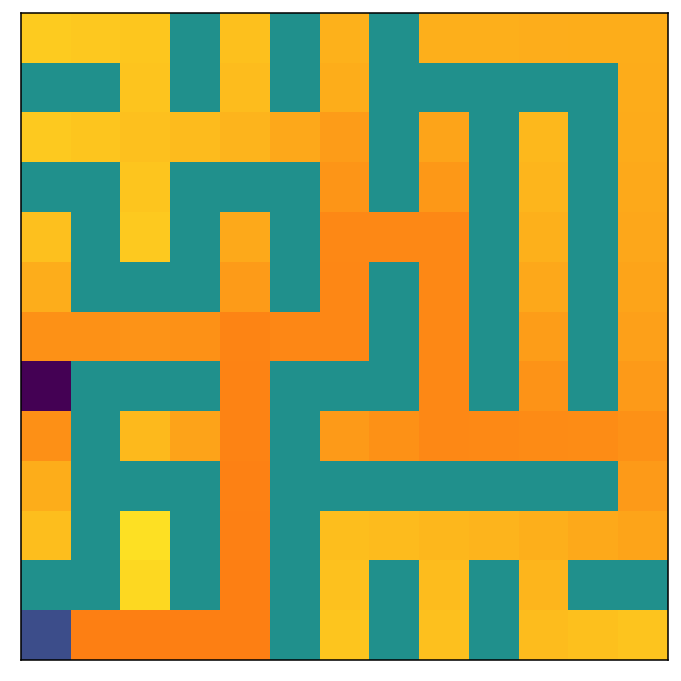

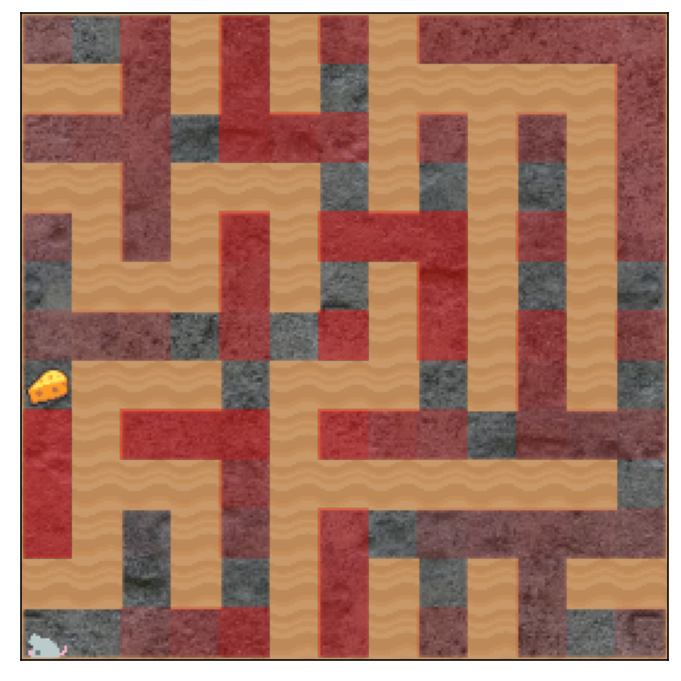

In [193]:
show_grid_heatmap(venv=venv, heatmap=heatmap, ax_size=AX_SIZE)
show_grid_heatmap(venv=venv, heatmap=heatmap, ax_size=AX_SIZE, mode="human")

In [191]:
# Widget to visualize the heatmap for different seeds
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


@interact(seed=(0, 100))
def show_grid_heatmap_interactive(seed: int) -> None:
    """Show a heatmap over the maze using matplotlib.

    Args:
        seed: Seed of the maze
    """
    venv = maze.create_venv(num=1, start_level=seed, num_levels=1)
    vf: Dict = visualization.vector_field(venv, hook.network)
    grid: np.ndarray = maze.get_inner_grid_from_seed(seed)
    heatmap: np.ndarray = np.zeros_like(grid, dtype=np.float32)
    for coord in maze.get_legal_mouse_positions(grid):
        heatmap[coord] = maze.geometric_probability_path((0, 0), coord, vf)
    show_grid_heatmap(
        venv=venv, heatmap=heatmap, ax_size=AX_SIZE, mode="human"
    )

interactive(children=(IntSlider(value=50, description='seed'), Output()), _dom_classes=('widget-interact',))